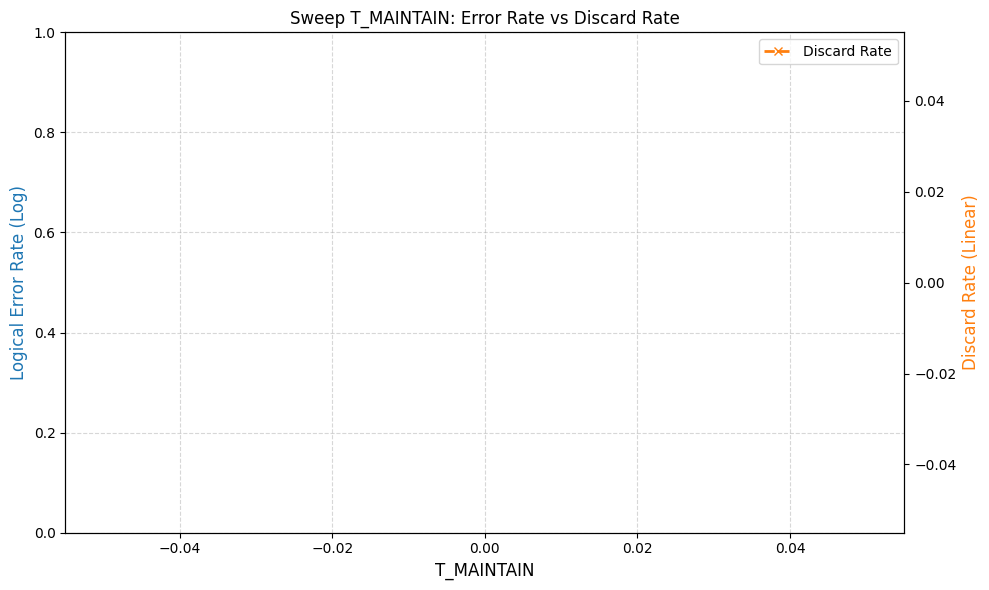

In [7]:
import matplotlib.pyplot as plt
import sinter
import csv
import json
from collections import defaultdict

# === 1. 手动读取 CSV (兼容旧版本 Sinter) ===
def read_sinter_csv_manual(path):
    stats = []
    with open(path, 'r', newline='') as f:
        # Sinter 的 CSV 是标准格式，可以直接通过 csv 库读取
        reader = csv.DictReader(f)
        for row in reader:
            # 跳过注释行（如果有）
            if not row.get('shots'): continue
            
            # 解析 JSON metadata
            meta = json.loads(row['json_metadata'])
            
            # 手动构建 TaskStats 对象
            # 1.13 版本 TaskStats 是 dataclass，支持关键字参数
            s = sinter.TaskStats(
                shots=int(row['shots']),
                errors=int(row['errors']),
                discards=int(row.get('discards', 0)), # 旧版本可能没有 discards 列
                seconds=float(row['seconds']),
                json_metadata=meta
            )
            stats.append(s)
    return stats

# 读取数据
filename = 'sinter_results_sweep_maintain.csv'     
stats = read_sinter_csv_manual(filename)

# === 2. 准备数据 ===
# 定义 X 轴变量 (根据你的 metadata 修改)
x_key = 'T_MAINTAIN'

# 手动聚合计算丢弃率 (为了确保兼容性，不依赖 sinter 内部函数)
data_map = defaultdict(lambda: {'shots': 0, 'discards': 0})
for s in stats:
    x_val = s.json_metadata[x_key]
    data_map[x_val]['shots'] += s.shots
    data_map[x_val]['discards'] += s.discards

# 提取 X 和 Y (Discard Rate)
sorted_xs = sorted(data_map.keys())
discard_rates = []
for x in sorted_xs:
    d = data_map[x]
    rate = d['discards'] / d['shots'] if d['shots'] > 0 else 0
    discard_rates.append(rate)

# === 3. 绘图 ===
fig, ax_err = plt.subplots(figsize=(10, 6))
ax_disc = ax_err.twinx() # 双 Y 轴

# --- 左轴：逻辑错误率 (使用 sinter 自带功能) ---
sinter.plot_error_rate(
    ax=ax_err,
    stats=stats,
    x_func=lambda s: s.json_metadata[x_key],
    group_func=lambda s: "Logical Error Rate",
    # plot_args={'color': 'tab:blue', 'marker': 'o', 'linewidth': 2}
)

# --- 右轴：丢弃率 (手动绘制) ---
ax_disc.plot(
    sorted_xs, 
    discard_rates, 
    color='tab:orange', 
    marker='x', 
    linestyle='--', 
    linewidth=2,
    label='Discard Rate'
)

# === 4. 设置与美化 ===
ax_err.set_xlabel(x_key, fontsize=12)
ax_err.set_ylabel("Logical Error Rate (Log)", fontsize=12, color='tab:blue')
ax_disc.set_ylabel("Discard Rate (Linear)", fontsize=12, color='tab:orange')
ax_err.grid(True, which='both', linestyle='--', alpha=0.5)
ax_err.set_title(f"Sweep {x_key}: Error Rate vs Discard Rate")

# 合并图例
lines1, labels1 = ax_err.get_legend_handles_labels()
lines2, labels2 = ax_disc.get_legend_handles_labels()
ax_err.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.tight_layout()
plt.show()


In [5]:
152/(100000000-71784304)

5.38707250035583e-06